In [29]:
import datetime
import time
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from operator import itemgetter
from itertools import groupby

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
from imblearn.under_sampling import EditedNearestNeighbours # doctest: +NORMALIZE_WHITESPACE

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import decomposition, tree


In [30]:
def Euro_converter(currency,amount):
    coversion_dict = {'SEK':0.09703,'MXN':0.04358,'AUD':0.63161,'NZD':0.58377,'GBP':1.13355}
    return round(amount * coversion_dict[currency])

In [31]:
data_set = pd.read_csv('data_for_student_case.csv')

#Construct the dataframe format
#Delete entries that have been recognised as Refuced transactions
data_set=data_set.loc[data_set['simple_journal']!='Refused']
data_set = data_set.loc[data_set['mail_id']!='emailNA']
#Convert amount into Euros
data_set['EuroAmount']=data_set.apply(lambda row: Euro_converter(row['currencycode'],row['amount']),axis=1)
#Convert creatiomn date into datetime format and extract each month, day, year,hour
data_set['creationdate'] = pd.to_datetime(data_set['creationdate'],format='%Y-%m-%d %H:%M:%S')
data_set['bookingdate'] = pd.to_datetime(data_set['bookingdate'],format='%Y-%m-%d %H:%M:%S')
data_set['creation_month'] = data_set.creationdate.dt.month
data_set['creation_year'] = data_set.creationdate.dt.year
data_set['creation_day'] = data_set.creationdate.dt.day
data_set['creation_hour'] = data_set.creationdate.dt.hour
#label column to have simple_journal in binary format
data_set['label'] = np.where(data_set['simple_journal']=='Chargeback', 1, 0)

data_set = data_set.dropna(axis=0, how='any')
print(np.asarray(data_set).shape)




(223172, 23)


In [32]:
############ Data Aggregation ###########

#number of transactions of specific card each creation_month
df=data_set[['card_id','creation_month']]
card_per_month = df.groupby(['card_id','creation_month'], as_index=False)
df['card_month'] = 1
a = card_per_month.sum()
print(data_set.shape)
print(a.shape)
data_set=pd.merge(data_set,a,how='inner')

print(np.asarray(data_set).shape)


# WRONG FEATURES GENERATED !!!!!

#number of transactions for date
day = data_set[['card_id','creationdate']]
day['date']=[x.date() for x in day['creationdate']]
day['card_id_day'] = 1
card_per_day = day.groupby(['card_id','date'], as_index=False) 
dd = card_per_day.sum()
print(data_set.shape)
print(dd.shape)
data_set=pd.merge(data_set,dd,how='inner')

print(np.asarray(data_set).shape)
print(data_set)
print(dd)

data_set.to_csv('dataset.csv')
dd.to_csv('dd.csv')








#currency type over month
currency = data_set[['currencycode','creation_month']]
currency['currency_month'] = 1
cur_per_month = currency.groupby(['currencycode','creation_month'], as_index=False)
cu = cur_per_month.sum()
data_set=pd.merge(data_set,cu,how='inner')


#Merchant type over month
Merchant = data_set[['accountcode','creation_month']]
Merchant['merchant_month'] = 1
mer_per_month = Merchant.groupby(['accountcode','creation_month'], as_index=False)
me = mer_per_month.sum()
data_set=pd.merge(data_set,me,how='inner')


#We select specific features from the original dataset
selected_features = [ 'issuercountrycode', 'txvariantcode', 'EuroAmount', 'amount',
                            'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'simple_journal',
                            'cvcresponsecode', 'accountcode','creation_hour', 'creation_day',
                            'creation_month', 'creation_year', 'ip_id',
                             'mail_id', 'bin', 'card_id','card_month','card_id_day','currency_month','merchant_month']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(223172, 23)
(210818, 3)
(223172, 24)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(223172, 24)
(220507, 3)
(303309, 26)
          txid         bookingdate issuercountrycode txvariantcode       bin  \
0            1 2015-11-09 14:26:51                MX      mccredit  530056.0   
1            2 2015-11-09 14:27:38                MX      mccredit  547046.0   
2            3 2015-11-23 16:34:16                MX      mccredit  528843.0   
3            4 2015-11-23 16:34:51                MX      mccredit  547146.0   
4            5 2015-11-09 14:26:08                MX   visaclassic  477291.0   
5            6 2015-11-09 14:26:25                MX   visaclassic  493161.0   
6            7 2015-11-09 14:26:47                MX   visaclassic  477291.0   
7            8 2015-11-23 16:34:29                MX      mccredit  520416.0   
8            9 2015-12-08 19:58:35                MX   visaclassic  477291.0   
9           10 2015-11-09 14:25:50                MX      mccredit  549138.0   
10          11 2015-11-23 16:34:29                MX      mccredit  520416.0   
11

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'],'value': [5, 2, 3, 5]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'], 'value': [5, 6, 7, 8]})
print(df1)
print(np.asarray(df1).shape)
print(df2)
print(np.asarray(df2).shape)
df2 = df2.merge(df1, how='inner')
print(df2)
print(np.asarray(df2).shape)

  lkey  value
0  foo      5
1  bar      2
2  baz      3
3  foo      5
(4, 2)
  rkey  value
0  foo      5
1  bar      6
2  baz      7
3  foo      8
(4, 2)
  rkey  value lkey
0  foo      5  foo
1  foo      5  foo
(2, 3)


In [6]:
all_features = data_set[selected_features]
all_features = all_features.dropna(axis=0, how='any')

all_features['label'] = np.where(all_features['simple_journal']=='Chargeback', 1, 0)
label = all_features['label']
enc_label = all_features['label']

all_features = all_features.drop(['txvariantcode','amount','creation_hour', 'creation_month', 'creation_year','simple_journal', 'label', 'mail_id', 'ip_id'],axis=1)

#this function is created specifically for the columns mail_id, ip_id, card_id, bin
#these columns usually contain unique data since each one of these are personal
#we identified some patterns, like that the most of the bins are used many times
#also there are card_ids frequently used
#we add this information as feature to see if our results will become better
def personal_data_encoding(column, threshold):
    count = dict(all_features[column].value_counts())
    mapping = {}
    for id in count.keys():
        if count[id]>threshold:
            mapping[id] = id
        else:
        	#we don't care for the appearances of 
            mapping[id] = 'dc'
    all_features[column] = all_features[column].map(mapping)



personal_data_encoding('bin',3)
personal_data_encoding('card_id',10)
encoded_feat = pd.get_dummies(all_features)

In [7]:
def pca(feature_vector, labels, comp=200):
    print("Starting PCA")
    pca = decomposition.PCA(n_components=comp)
    coeff = pca.fit_transform(feature_vector)
    return coeff

In [8]:
comp = 100
test_feature = pca(encoded_feat, enc_label, comp)
test_ff = pd.DataFrame(test_feature)

Starting PCA


In [9]:
TP, FP, FN, TN = 0, 0, 0, 0
x_array = np.array(test_ff)
y_array = np.array(enc_label)
usx = x_array
usy = y_array
usx = usx.astype(np.float64)
usy = usy.astype(np.float64)

In [10]:
def classification(data_manipulation, classifier):
    
    warnings.filterwarnings("ignore")
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    if classifier == 'knn':
        print("KNN Classifier")
        clf = neighbors.KNeighborsClassifier(n_jobs=-1)
    elif classifier == 'random forest':
        print("Random Forest Classifier")
        clf = RandomForestClassifier(n_jobs=-1)
    elif classifier == 'adaboost':
        print("AdaBoost Classifier")
        clf = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)

    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0
    total_prob = []

    tprs_set = []
    fprs_set = []
    fns_set = []
    tns_set = []
    y_set = []
    probs_set = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    if data_manipulation == 'SMOTE':
        print("SMOTE")
    elif data_manipulation == 'SMOTE + Tomek':
        print("SMOTE + Tomek")
    elif data_manipulation == 'UnderSampling':
        print("UnderSampling")
    elif data_manipulation == 'pure':
        print("Wihtout data augmentation")

    for train_index, test_index in kf.split(usx, usy):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        [x_train, x_test] = usx[train_index], usx[test_index]
        [y_train, y_test] = usy[train_index], usy[test_index]
    
        ## >>>Data Augmentation!<<<
        if data_manipulation == 'SMOTE':
            sm = SMOTE(random_state=42, ratio = 0.5)
            x_res, y_res = sm.fit_sample(x_train, y_train)
        elif data_manipulation == 'SMOTE + Tomek':
            smt = SMOTETomek(random_state=42, ratio = 0.5)
            x_res, y_res = smt.fit_sample(x_train, y_train)
        elif data_manipulation == 'UnderSampling':
            enn = EditedNearestNeighbours(ratio = 0.5)
            x_res, y_res = enn.fit_sample(x_train, y_train)
        elif data_manipulation == 'pure':
            x_res = x_train
            y_res = y_train
        
        ## >>>Classification!<<<

        clf.fit(x_res, y_res)
        y_predict = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:,1]
        i +=1

        for i in range(len(y_predict)):
            if y_test[i] == 1 and y_predict[i] == 1:
                TP += 1
            if y_test[i] == 0 and y_predict[i] == 1:
                FP += 1
            if y_test[i] == 1 and y_predict[i] == 0:
                FN += 1
            if y_test[i] == 0 and y_predict[i] == 0:
                TN += 1
    #     print('TP: ' + str(TP))
    #     print('FP: ' + str(FP))
    #     print('FN: ' + str(FN))
    #     print('TN: ' + str(TN))
        total_TP = total_TP + TP
        total_FP = total_FP + FP
        total_FN = total_FN + FN
        total_TN = total_TN + TN
        tprs_set.append(TP)
        fprs_set.append(FP)
        fns_set.append(FN)
        tns_set.append(TN)
        probs_set.extend(probs)
        y_set.extend(y_test)
    #     tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()


    total_TP = np.array(total_TP)
    total_FP = np.array(total_FP)
    total_FN = np.array(total_FN)
    total_TN = np.array(total_TN)

    print('10 fold cross-validations TP:', total_TP)
    print('10 fold cross-validations FP:', total_FP)
    print('10 fold cross-validations FN:', total_FN)
    print('10 fold cross-validations TN:', total_TN)

    False_Positive_Rate, True_Positive_Rate, threshold = roc_curve(y_set, probs_set)
    aucTree = roc_auc_score(y_set, probs_set)
    plt.title(classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, color='r', label='Chance', alpha=.8)
    label = 'AUC ' + data_manipulation + ' ' + str(round(aucTree, 2))
    plt.plot(False_Positive_Rate, True_Positive_Rate, color='blue',label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
#     plt.savefig(classifier)
    plt.show()

Random Forest Classifier
SMOTE
10 fold cross-validations TP: 139
10 fold cross-validations FP: 250
10 fold cross-validations FN: 267
10 fold cross-validations TN: 306082


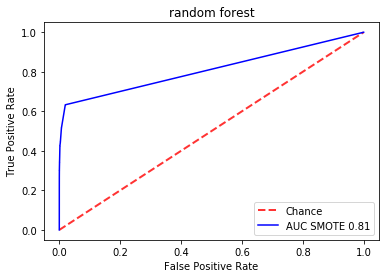

Random Forest Classifier
SMOTE + Tomek
10 fold cross-validations TP: 143
10 fold cross-validations FP: 275
10 fold cross-validations FN: 263
10 fold cross-validations TN: 306057


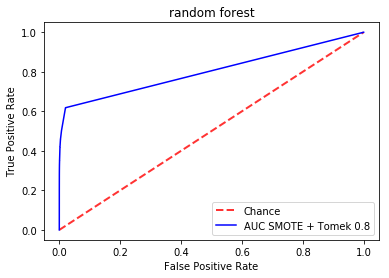

Random Forest Classifier
UnderSampling
10 fold cross-validations TP: 111
10 fold cross-validations FP: 24
10 fold cross-validations FN: 295
10 fold cross-validations TN: 306308


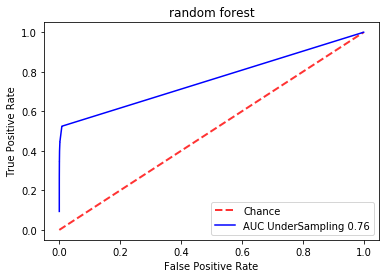

In [11]:
classification('SMOTE', 'random forest')
classification('SMOTE + Tomek', 'random forest')
classification('UnderSampling', 'random forest')